# Analysing samsung stocks data and working on classification models to predict them

The primary goal of this study is to develop a models to classify to sell or buy the stocks of samsung 

We have used yahoo finance library to fetch data of samsung stocks data

Machine Learning Models that are used in this project:
-  K-Nearest Neighbors (KNN)
- Random Forest Classifier (RF) 
- Gradient Boosting Classifier (GB) 
- Support Vector Machines (SVMs) 
- XGBoost Classifier

Next day closing price; Golden Cross

**Strategy 1:** : If the next trading day's close price is greater than today's close price then the signal 
is ‘buy’, otherwise ‘sell’

**Strategy 2:** strategy_2: Utilize the 50-day moving average vs the 200-day moving average. A golden cross
(or golden crossover) is a chart pattern that involves a short-term moving average crossing above 
a long-term moving average. Typically, the 50-day MA is used as the short-term average, and the 
200-day MA is used as the long-term average. This is an indicator of bullish (buying) signal. 
(See Figure 1 below) 
A death cross is basically the opposite of a golden cross. It’s a chart pattern where a short-term 
MA crosses below a long-term MA. For example, the 50-day MA crosses below the 200-day 
MA. As such, a death cross is typically considered to be a bearish (selling) signal.


  Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error, f1_score , accuracy_score, classification_report ,recall_score,precision_score
from matplotlib import pyplot as plt
 
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


Defining method to fetch stocks using ytfinance library

In [2]:
def fetch_stocks(stock_name, ticker ,start_date,end_date):
    try:
        print(f"Fetching {stock_name} stocks data from {start_date} to {end_date}")
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        print(f"Error occured while fetching stock data : {e}")

samsung_ticker = "005930.KS"  
start_date = "2015-01-01"
end_date = datetime.datetime.today().date() 

stocks_data = fetch_stocks("Samsung",samsung_ticker , start_date,end_date )




Fetching Samsung stocks data from 2015-01-01 to 2023-10-05
[*********************100%%**********************]  1 of 1 completed


Visualizing data

In [3]:
stocks_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26800.0,26800.0,26540.0,26600.0,21567.841797,8774950
2015-01-05,26720.0,26720.0,26260.0,26660.0,21616.490234,10139500
2015-01-06,26300.0,26340.0,25760.0,25900.0,21000.267578,15235500
2015-01-07,25880.0,26220.0,25640.0,26140.0,21194.861328,14322750
2015-01-08,26780.0,26780.0,26200.0,26280.0,21308.375000,14477600


In [4]:
stocks_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-22,68300.0,68900.0,68300.0,68800.0,68800.0,9897840
2023-09-25,68500.0,69700.0,68500.0,69400.0,69400.0,13582516
2023-09-26,70000.0,70000.0,68400.0,68600.0,68600.0,13143470
2023-09-27,68600.0,69100.0,68200.0,68400.0,68400.0,14886491
2023-10-04,67400.0,67700.0,66700.0,67500.0,67500.0,23361149


In [5]:
stocks_data.shape

(2152, 6)

Cleaning data

In [6]:
stocks_data = stocks_data.rename({"Adj Close" : "adj_close" , "Open" : "open" , "Close":"close" , "Volume" : "volume"}, axis = 1)

In [7]:
def remove_unwanted_columns(data  , column):
    for i in column :
        if i in data.columns:
            data.drop( i, axis = 1, inplace = True)

remove_unwanted_columns(stocks_data , ["High" , "Low", "close"])

In [8]:
stocks_data_2 = stocks_data.copy()

In [9]:
def return_null_value_summary(data):
    return data.isnull().sum().to_dict()

def delete_null_values(data):
    data.dropna(inplace=True)
    
return_null_value_summary(stocks_data)

{'open': 0, 'adj_close': 0, 'volume': 0}

Working on startegy - 1 logic

In [10]:
stocks_data['signal'] =  (np.where(stocks_data['adj_close'].shift(-1) > stocks_data['adj_close'], 1, 0))
stocks_data['stock_signal'] =  (np.where(stocks_data['adj_close'].shift(-1) > stocks_data['adj_close'], 1, -1))

stocks_data['moving_avg'] = stocks_data['adj_close'].rolling(window=10).mean()


In [11]:
delete_null_values(stocks_data)
return_null_value_summary(stocks_data)

{'open': 0,
 'adj_close': 0,
 'volume': 0,
 'signal': 0,
 'stock_signal': 0,
 'moving_avg': 0}

Viewing data after adding columns

In [12]:
stocks_data.head()

,open,adj_close,volume,signal,stock_signal,moving_avg
Date,,,,,,
2015-01-15,26900.0,21632.707031,14103900,0,-1,21449.460352
2015-01-16,26680.0,21340.806641,13568500,1,1,21426.756836
2015-01-19,26580.0,21778.648438,6672950,1,1,21442.972656
2015-01-20,27000.0,22248.935547,13278050,1,1,21567.839453
2015-01-21,27340.0,22621.908203,16612650,0,-1,21710.544141


In [13]:
stocks_data.tail()

,open,adj_close,volume,signal,stock_signal,moving_avg
Date,,,,,,
2023-09-22,68300.0,68800.0,9897840,1,1,70320.0
2023-09-25,68500.0,69400.0,13582516,0,-1,70180.0
2023-09-26,70000.0,68600.0,13143470,0,-1,69990.0
2023-09-27,68600.0,68400.0,14886491,0,-1,69740.0
2023-10-04,67400.0,67500.0,23361149,0,-1,69320.0


Defining methods to split data and initilize classification models and evulate them 

In [14]:
def split_data(feature , dependent,  random_state = 20):
    X_train, X_test, Y_train, Y_test = train_test_split(
                                    feature,  dependent,  test_size = 0.2 ,  random_state = random_state)
    print(f"Train and test data shapes {X_train.shape} , {X_test.shape}" , end = "\n\n")
    return X_train, X_test, Y_train, Y_test

In [15]:
def initilize_classification_models():
    random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 9, criterion = "gini")
    xg_boost_classifier = XGBClassifier(base_score=0.5, booster='gbtree',learning_rate=1)
    knn_classifier = KNeighborsClassifier(n_neighbors=3)
    gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    svm_classifier = SVC()


    return  random_forest_classifier , xg_boost_classifier , knn_classifier , gb_classifier,svm_classifier

random_forest_classifier , xg_boost_classifier , knn_classifier , gb_classifier,svm_classifier = initilize_classification_models()
final_data_frame = pd.DataFrame()

In [16]:
def evaluate_classification(model, X_train, X_test, Y_train, Y_test  ):
    model.fit(X_train,Y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)
    recallscore = recall_score(Y_test, predictions,average='micro')
    precision = precision_score(Y_test, predictions, average='micro')
    f1score = f1_score(Y_test, predictions , average='micro') 
    df = pd.DataFrame({"Model"           : [type(model).__name__],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                      })
    return df.reset_index(drop = True) 



Plotting heat maps to identify corelation between two attributes

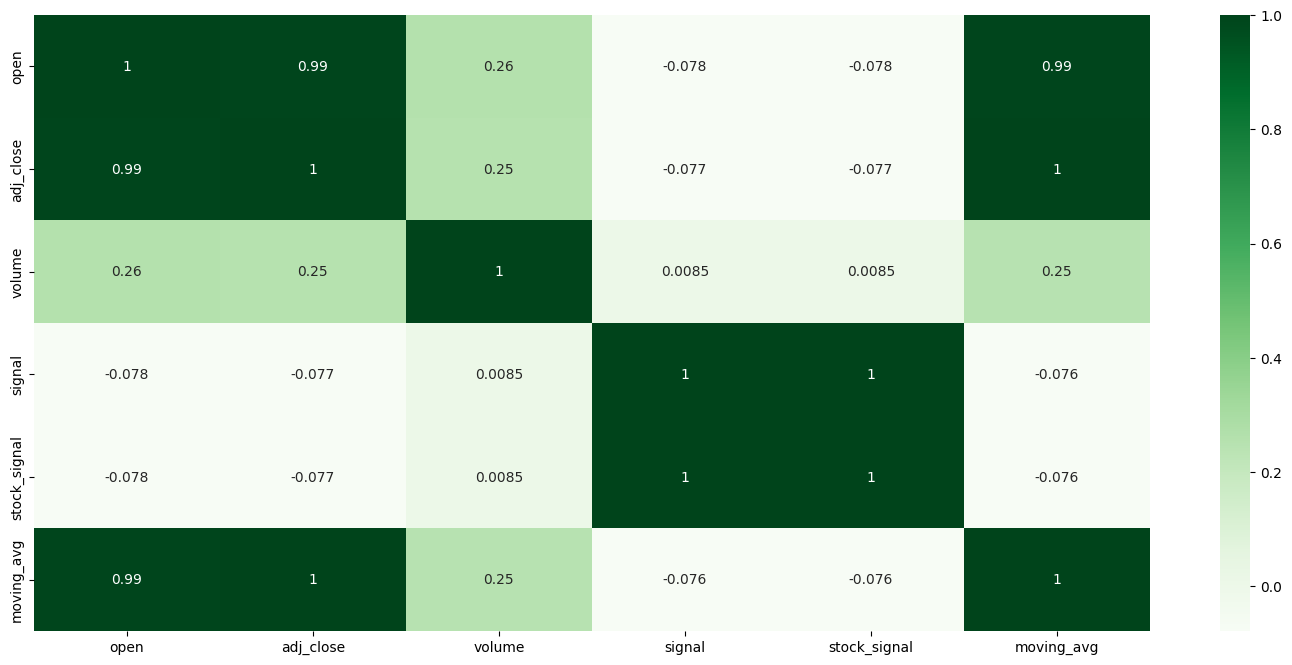

In [17]:
plt.subplots(figsize = ([18,8]))
sns.heatmap(stocks_data.corr(), annot=True, cmap="Greens")
plt.show()

spliting data frame

In [18]:
feature_columns = ['open', 'adj_close', 'volume', 'moving_avg']
dependent_column = ['signal']
X_train, X_test, y_train, y_test  = split_data(stocks_data[feature_columns] , stocks_data[dependent_column])

Train and test data shapes (1714, 4) , (429, 4)



Evaluating model

In [19]:
final_dataframe = pd.DataFrame()  
final_dataframe = final_dataframe.append(evaluate_classification(random_forest_classifier,X_train, X_test, y_train, y_test ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(xg_boost_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(knn_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(gb_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(svm_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)

In [20]:
final_dataframe

,Model,Accuracy,Recall,Precision,f1-score
0,RandomForestClassifier,0.531469,0.531469,0.531469,0.531469
1,XGBClassifier,0.529138,0.529138,0.529138,0.529138
2,KNeighborsClassifier,0.496503,0.496503,0.496503,0.496503
3,GradientBoostingClassifier,0.510490,0.510490,0.510490,0.510490
4,SVC,0.477855,0.477855,0.477855,0.477855


From the above dataframe we can identify Random forest is the best model to fit our data and classify 

# Startegy - 2 

In [21]:
stocks_data_2.head()

,open,adj_close,volume
Date,,,
2015-01-02,26800.0,21567.841797,8774950
2015-01-05,26720.0,21616.490234,10139500
2015-01-06,26300.0,21000.267578,15235500
2015-01-07,25880.0,21194.861328,14322750
2015-01-08,26780.0,21308.375000,14477600


adding moving averages to implement startegy 2

In [22]:
stocks_data_2['50DaySMA'] = stocks_data_2['adj_close'].rolling(window=50).mean()
stocks_data_2['200DaySMA'] = stocks_data_2['adj_close'].rolling(window=200).mean()

stocks_data_2['signal'] = np.where(stocks_data_2['50DaySMA'] > stocks_data_2['200DaySMA'], 1, 0)
stocks_data_2['stock_signal'] = np.where(stocks_data_2['50DaySMA'] > stocks_data_2['200DaySMA'], 1, -1)


print(return_null_value_summary(stocks_data_2))
delete_null_values(stocks_data_2)



{'open': 0, 'adj_close': 0, 'volume': 0, '50DaySMA': 49, '200DaySMA': 199, 'signal': 0, 'stock_signal': 0}


In [23]:
return_null_value_summary(stocks_data_2)


{'open': 0,
 'adj_close': 0,
 'volume': 0,
 '50DaySMA': 0,
 '200DaySMA': 0,
 'signal': 0,
 'stock_signal': 0}

In [24]:
stocks_data_2.head()

,open,adj_close,volume,50DaySMA,200DaySMA,signal,stock_signal
Date,,,,,,,
2015-10-21,25300.0,20610.984375,6978350,18684.263086,21065.873389,0,-1
2015-10-22,25600.0,20773.277344,11533650,18729.380156,21061.900566,0,-1
2015-10-23,26000.0,20919.345703,13153550,18772.225078,21058.414844,0,-1
2015-10-26,25960.0,20968.021484,7608250,18817.017305,21058.253613,0,-1
2015-10-27,25640.0,21065.402344,6612050,18868.301328,21057.606318,0,-1


Plotting heat map to identify corelation between variables

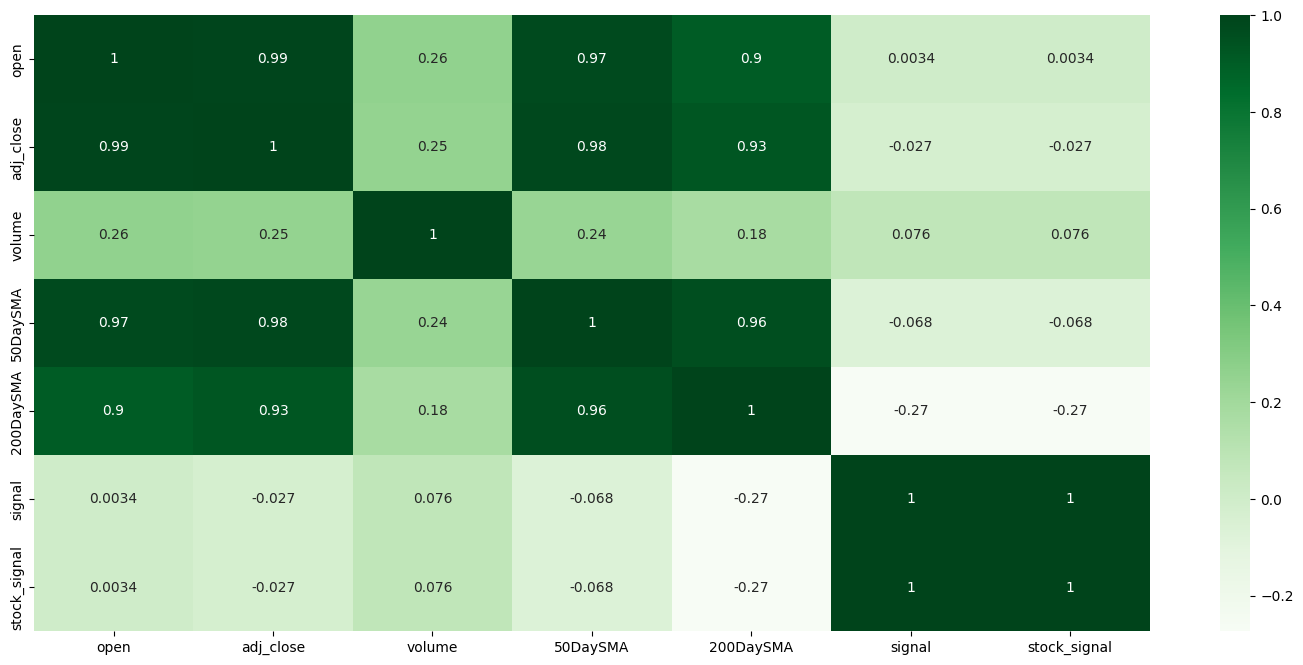

In [25]:
plt.subplots(figsize = ([18,8]))
sns.heatmap(stocks_data_2.corr(), annot=True, cmap="Greens")
plt.show()

In [26]:
feature_columns = ['open', 'adj_close', '50DaySMA','200DaySMA']
dependent_column = ['signal']
X_train, X_test, y_train, y_test  = split_data(stocks_data_2[feature_columns] , stocks_data_2[dependent_column])

Train and test data shapes (1562, 4) , (391, 4)



Initilizing models

In [27]:
random_forest_classifier , xg_boost_classifier , knn_classifier , gb_classifier,svm_classifier = initilize_classification_models()
final_data_frame = pd.DataFrame()

In [28]:
final_dataframe = pd.DataFrame()  
final_dataframe = final_dataframe.append(evaluate_classification(random_forest_classifier,X_train, X_test, y_train, y_test ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(xg_boost_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(knn_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(gb_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)
final_dataframe = final_dataframe.append(evaluate_classification(svm_classifier,X_train, X_test, y_train, y_test  ),ignore_index = True)

In [29]:
final_dataframe.head()

,Model,Accuracy,Recall,Precision,f1-score
0,RandomForestClassifier,0.994885,0.994885,0.994885,0.994885
1,XGBClassifier,0.987212,0.987212,0.987212,0.987212
2,KNeighborsClassifier,0.974425,0.974425,0.974425,0.974425
3,GradientBoostingClassifier,0.984655,0.984655,0.984655,0.984655
4,SVC,0.936061,0.936061,0.936061,0.936061


From above data frame, We can identify XGB classifier is the best model among all other models followed by Gradient Boosting and Random forest classifier 

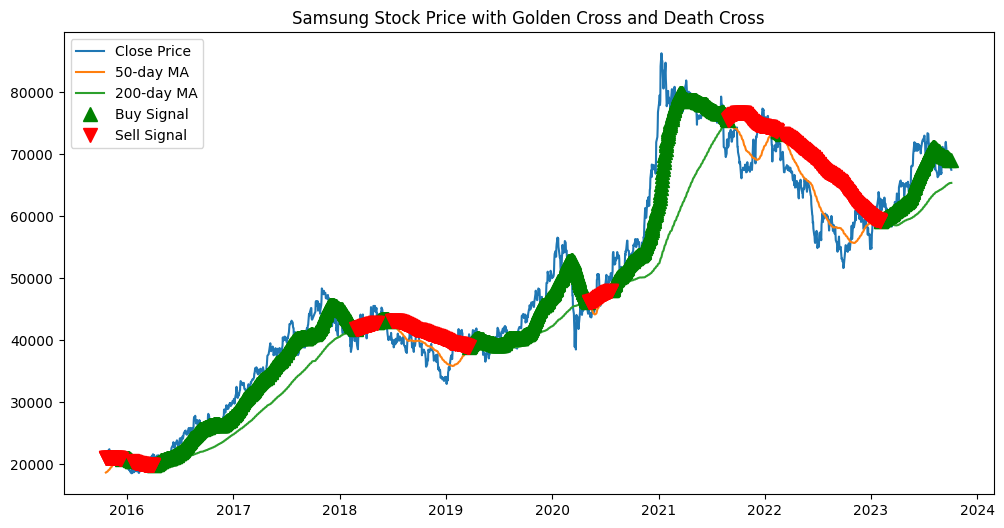

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(stocks_data_2['adj_close'], label='Close Price')
plt.plot(stocks_data_2['50DaySMA'], label='50-day MA')
plt.plot(stocks_data_2['200DaySMA'], label='200-day MA')
plt.plot(stocks_data_2[stocks_data_2['signal'] == 1.0].index,
         stocks_data_2['50DaySMA'][stocks_data_2['signal'] == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

plt.plot(stocks_data_2[stocks_data_2['signal'] == 0.0].index,
         stocks_data_2['200DaySMA'][stocks_data_2['signal'] == 0.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Samsung Stock Price with Golden Cross and Death Cross')
plt.legend()
plt.show()

From the above plot, We can check stocks of samsung are continously rising untill 2021, later it faced a slight downfall and got picked up in 2023. As per current day, They are doing great with profits.

# Hyper parameter Tuning

In [31]:
params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10]
              }

xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist')
clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

clf.fit(X_train, y_train)


xgBoostClassifier = clf.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [32]:
final_dataframe = final_dataframe.append(evaluate_classification(xgBoostClassifier,X_train, X_test, y_train, y_test ),ignore_index = True)


In [33]:
final_dataframe.head(10)

,Model,Accuracy,Recall,Precision,f1-score
0,RandomForestClassifier,0.994885,0.994885,0.994885,0.994885
1,XGBClassifier,0.987212,0.987212,0.987212,0.987212
2,KNeighborsClassifier,0.974425,0.974425,0.974425,0.974425
3,GradientBoostingClassifier,0.984655,0.984655,0.984655,0.984655
4,SVC,0.936061,0.936061,0.936061,0.936061
5,XGBClassifier,0.987212,0.987212,0.987212,0.987212


In [34]:

param_grid = {
'n_estimators': [25, 50, 100, 150],
'max_depth': [3, 6, 9],
'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
grid_search.fit(X_train, y_train)
randomForestTunedClassifier = grid_search.best_estimator_



In [35]:
final_dataframe = final_dataframe.append(evaluate_classification(randomForestTunedClassifier,X_train, X_test, y_train, y_test ),ignore_index = True)


In [36]:
final_dataframe.head(10)

,Model,Accuracy,Recall,Precision,f1-score
0,RandomForestClassifier,0.994885,0.994885,0.994885,0.994885
1,XGBClassifier,0.987212,0.987212,0.987212,0.987212
2,KNeighborsClassifier,0.974425,0.974425,0.974425,0.974425
3,GradientBoostingClassifier,0.984655,0.984655,0.984655,0.984655
4,SVC,0.936061,0.936061,0.936061,0.936061
5,XGBClassifier,0.987212,0.987212,0.987212,0.987212
6,RandomForestClassifier,0.941176,0.941176,0.941176,0.941176


After implementing tuning on couple of models like Random forest and XGB classifier , We can identify not much significant raise in performance of models.